Importando bibliotecas necessárias

In [44]:
#importações necessárias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import joblib


importando e analisando DataSet

In [2]:
df = pd.read_csv('data_aumentada.csv', sep=";",encoding='latin-1')

In [3]:
#corrigindo o nome da coluna
df.rename(columns={'mês':'mes'}, inplace=True)

In [5]:
df.head()

,mes,consumo_kwh,valor_reais,mes
0,2025-01,597.07,794.92,2025-01-01
1,2025-02,547.54,731.62,2025-02-01
2,2025-03,499.95,651.91,2025-03-01
3,2025-04,543.57,742.65,2025-04-01
4,2025-05,534.65,754.99,2025-05-01


In [15]:
# remove coluna de índice salva sem querer (se existir)
df = df.loc[:, ~df.columns.duplicated()]
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

In [16]:
df.head()

,mes,consumo_kwh,valor_reais
0,2025-01,597.07,794.92
1,2025-02,547.54,731.62
2,2025-03,499.95,651.91
3,2025-04,543.57,742.65
4,2025-05,534.65,754.99


In [17]:
#convertendo mes para datetime
df['mes'] = pd.to_datetime(df['mes'])


In [18]:
df = df.sort_values('mes')

In [22]:
print(df.head(100))

           mes  consumo_kwh  valor_reais
0   2025-01-01       597.07       794.92
156 2025-01-01       665.74       796.17
520 2025-01-01       598.03       829.51
403 2025-01-01       575.51       858.33
598 2025-01-01       576.50       757.37
..         ...          ...          ...
755 2025-02-01       426.28       745.12
313 2025-02-01       605.00       731.58
209 2025-02-01       514.39       738.13
274 2025-02-01       456.17       695.22
599 2025-02-01       621.88       721.70

[100 rows x 3 columns]


In [24]:
df.info()

<class 'pandas.DataFrame'>
Index: 923 entries, 0 to 922
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   mes          923 non-null    datetime64[us]
 1   consumo_kwh  923 non-null    float64       
 2   valor_reais  923 non-null    float64       
dtypes: datetime64[us](1), float64(2)
memory usage: 28.8 KB


In [25]:
type(df)

pandas.DataFrame

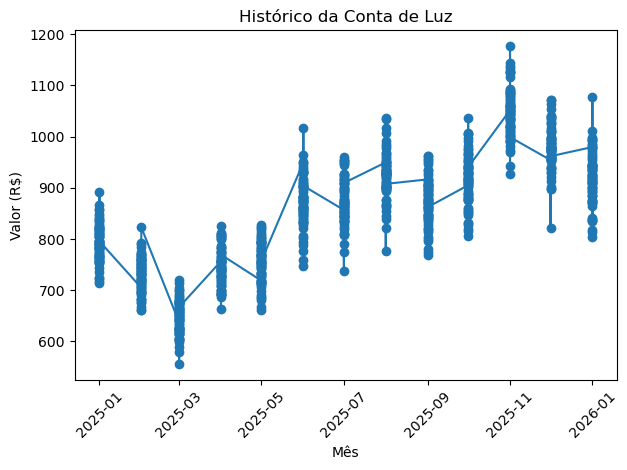

In [26]:


plt.figure()
plt.plot(df["mes"], df["valor_reais"], marker="o")
plt.xticks(rotation=45)
plt.title("Histórico da Conta de Luz")
plt.xlabel("Mês")
plt.ylabel("Valor (R$)")
plt.tight_layout()
plt.show()


Criando features inteligentes


In [27]:
df['consumo_anterior'] = df['consumo_kwh'].shift(1)
df['media_3_messes'] = df['consumo_kwh'].rolling(3).mean()
df['mes_num'] = df['mes'].dt.month

In [28]:
df.head()

,mes,consumo_kwh,valor_reais,consumo_anterior,media_3_messes,mes_num
0,2025-01-01,597.07,794.92,NaN,NaN,1
156,2025-01-01,665.74,796.17,597.07,NaN,1
520,2025-01-01,598.03,829.51,665.74,620.280000,1
403,2025-01-01,575.51,858.33,598.03,613.093333,1
598,2025-01-01,576.50,757.37,575.51,583.346667,1


In [29]:
df.dropna()

,mes,consumo_kwh,valor_reais,consumo_anterior,media_3_messes,mes_num
520,2025-01-01,598.03,829.51,665.74,620.280000,1
403,2025-01-01,575.51,858.33,598.03,613.093333,1
598,2025-01-01,576.50,757.37,575.51,583.346667,1
65,2025-01-01,565.95,789.75,576.50,572.653333,1
858,2025-01-01,599.53,835.53,565.95,580.660000,1
...,...,...,...,...,...,...
324,2026-01-01,584.18,883.16,701.83,663.680000,1
766,2026-01-01,668.24,992.78,584.18,651.416667,1
155,2026-01-01,690.10,899.56,668.24,647.506667,1
753,2026-01-01,627.46,961.71,690.10,661.933333,1


In [30]:
#removendo valores nulos e salvando em uma nova variavel
df2 = df.dropna()



Criando pipeline e grid de hiperparâmetro

In [47]:
parametros = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
rf = RandomForestRegressor(random_state=42)

Treinamento do modelo 


In [48]:

x = df2[[

        'consumo_anterior',
        'media_3_messes',
        'mes_num'
    ]]

y = df2['valor_reais']

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, random_state=42)

grid = GridSearchCV(
    rf,
    parametros,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid.fit(x_treino, y_treino)


print("Melhor modelo:", grid.best_params_)
print("Melhor score CV:", grid.best_score_)


Melhor modelo: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Melhor score CV: 0.8303792481440105


In [49]:
best_model = grid.best_estimator_


In [50]:
y_pred = best_model.predict(x_teste)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_teste, y_pred)
rmse = np.sqrt(mean_squared_error(y_teste, y_pred))
r2 = r2_score(y_teste, y_pred)

print(f"MAE: R$ {mae:.2f}")
print(f"RMSE: R$ {rmse:.2f}")
print(f"R²: {r2:.3f}")


MAE: R$ 37.78
RMSE: R$ 49.90
R²: 0.808


Expostando o modelo 

In [52]:
joblib.dump(best_model, 'modelo_conta_luz.joblib')
print("👌modelo salvo com sucesso!")

👌modelo salvo com sucesso!


Teste Rápido

In [126]:
#consumos = [520, 540, 550]  # últimos 3 meses informados pelo usuário

#consumo_atual = consumos[-1]
#consumo_anterior = consumos[-2]
#media_3_meses = sum(consumos) / len(consumos)
#mes_atual = 6  # junho

#exemplo = [[consumo_atual, consumo_anterior, media_3_meses, mes_atual]]

#previsao = modelo.predict(exemplo)

#print(f"Previsão da conta: R$ {previsao[0]:.2f}")


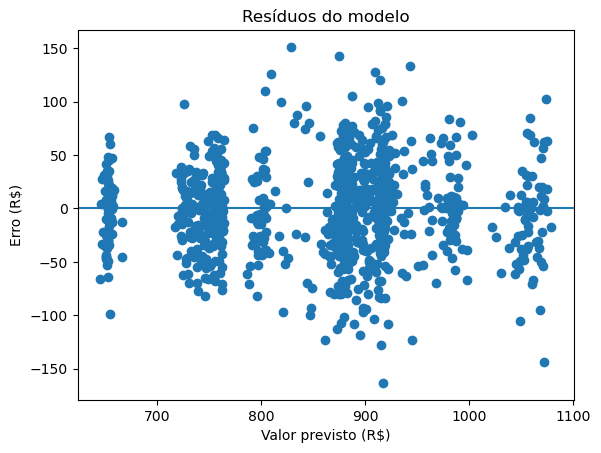

In [54]:
y_pred = best_model.predict(x)
residuos = y - y_pred

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_pred, residuos)
plt.axhline(0)
plt.xlabel("Valor previsto (R$)")
plt.ylabel("Erro (R$)")
plt.title("Resíduos do modelo")
plt.show()
